## Data analysis, preparation and visualization
Data preparation for the ECG challenge on Kaggle.

In [ ]:
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
from PIL import Image

In [ ]:
ROOT_DIR = Path('ECG_dataset/physionet-ecg-image-digitization')

#Why good categories? well, ehehe, I am alone, so I cannot segment everything. THese categories are the easier imeages to cut as
#theyy are kinda standardized and not too complex to handle. As a first attempt, I think is better not to overcomplicate.

GOOD_CATEGORIES = {'3', '4', '11', '12'}

CATEGORY_CUTS: Dict[str, Dict[str, List[int]]] = {
    '3':  {'x': [609, 1074, 1542],      'y': [500, 797, 1130, 1387]},
    '4':  {'x': [611, 1081, 1546],      'y': [505, 842, 1137, 1390]},
    '11': {'x': [602, 1072, 1542],      'y': [495, 807, 1144, 1387]},
    '12': {'x': [607, 1079, 1547],      'y': [509, 840, 1158, 1411]},
}

IMG_SUFFIXES = {'.png'}

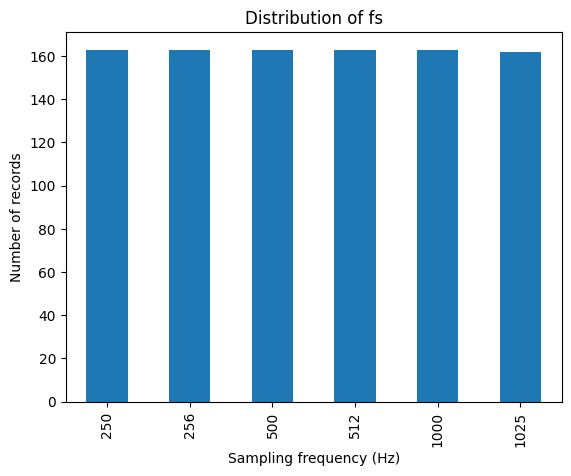

In [ ]:
def parse_category(name: str) -> str:
    """
    Extract trailing number:
    '1012423188-0003.png' -> '3'
    'something_0011.jpg'  -> '11'
    """
    base = name.rsplit('.', 1)[0]
    if '-' in base:
        tail = base.split('-')[-1]
    else:
        tail = base.split('_')[-1]
    tail = tail.lstrip('0') or '0'
    return tail


def load_all_images(root_dir: Path):
    """
    Yield (record_id, category, img_path) only for GOOD_CATEGORIES.
    """
    for sub in root_dir.iterdir():
        if not sub.is_dir():
            continue
        record_id = sub.name
        for img_path in sub.iterdir():
            if img_path.suffix.lower() not in IMG_SUFFIXES:
                continue
            cat = parse_category(img_path.name)
            if cat not in GOOD_CATEGORIES:
                continue
            yield record_id, cat, img_path

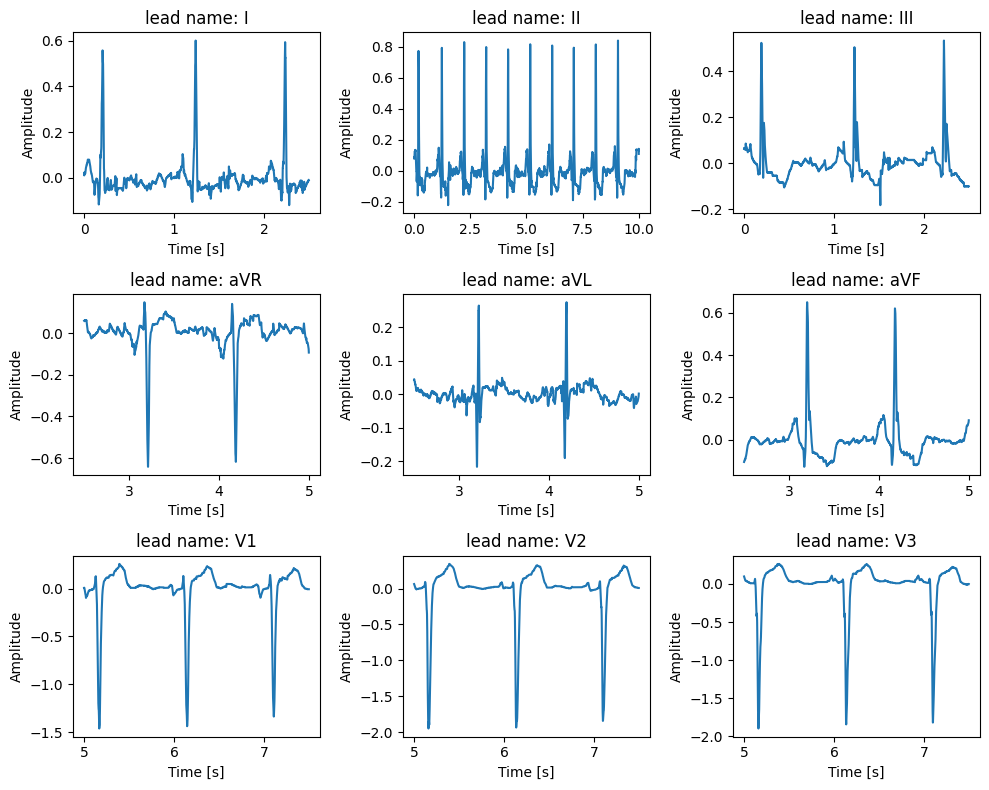

In [ ]:
def normalize_cuts(img: Image.Image, category: str) -> Tuple[List[int], List[int]]:
    cuts = CATEGORY_CUTS.get(category)
    if not cuts:
        raise ValueError(f'No cuts provided for category {category}')
    xs = sorted(set([0, *cuts['x'], img.width]))
    ys = sorted(set([0, *cuts['y'], img.height]))
    return xs, ys


def split_grid(img: Image.Image, x_cuts: List[int], y_cuts: List[int]) -> List[Image.Image]:
    panels = []
    for i in range(len(y_cuts) - 1):
        for j in range(len(x_cuts) - 1):
            box = (x_cuts[j], y_cuts[i], x_cuts[j+1], y_cuts[i+1])
            panels.append(img.crop(box))
    return panels


def reshape_panels(panels: List[Image.Image], rows: int, cols: int) -> List[List[Image.Image]]:
    if len(panels) != rows * cols:
        raise ValueError(f'Expected {rows*cols} panels, got {len(panels)}')
    return [panels[i*cols:(i+1)*cols] for i in range(rows)]


def concat_horizontal(images: List[Image.Image]) -> Image.Image:
    widths = [im.width for im in images]
    heights = [im.height for im in images]
    new_im = Image.new('RGB', (sum(widths), max(heights)))
    offset = 0
    for im in images:
        new_im.paste(im, (offset, 0))
        offset += im.width
    return new_im


In [ ]:
def process_horizontal_panels(panels: List[Image.Image], rows: int, cols: int):
    """
    Horizontal pages:

    - Top row (riga 0) = metadata (scartiamo)
    - Middle rows (1 .. rows-2) -> 12 short leads
    - Bottom row (rows-1) -> pieces of long lead, stitched horizontally
    """
    grid = reshape_panels(panels, rows, cols)
    if rows < 3:
        raise ValueError('Horizontal: need at least 3 rows (top, middle, bottom)')

    # central rows -> short leads
    middle_rows = list(range(1, rows-1))
    central_panels = [grid[r][c] for r in middle_rows for c in range(cols)]

    # bottom row -> long lead II
    bottom_row = [grid[rows-1][c] for c in range(cols)]
    long_lead = concat_horizontal(bottom_row)

    return central_panels, long_lead


def split_page(img: Image.Image, category: str):
    """
    For now, assume all GOOD_CATEGORIES are horizontal layouts.
    Return: 12 short leads + long lead image.
    """
    x_cuts, y_cuts = normalize_cuts(img, category)
    panels = split_grid(img, x_cuts, y_cuts)
    rows = len(y_cuts) - 1
    cols = len(x_cuts) - 1

    leads, long_lead = process_horizontal_panels(panels, rows, cols)

    if len(leads) != 12:
        print(f"[WARN] category {category}: got {len(leads)} short leads instead of 12")

    return leads, long_lead

5 4
[OK] 1006867983 cat 6 orient horizontal -> 12 leads; long (729, 4000)
5 4
[OK] 1006867983 cat 12 orient horizontal -> 12 leads; long (241, 2138)
5 4
[OK] 1006867983 cat 4 orient horizontal -> 12 leads; long (262, 2130)
5 4
[OK] 1006867983 cat 10 orient horizontal -> 12 leads; long (826, 4032)
5 4
[OK] 1006867983 cat 11 orient horizontal -> 12 leads; long (265, 2136)
5 4
[OK] 1006867983 cat 5 orient horizontal -> 12 leads; long (726, 4032)
4 5
[OK] 1006867983 cat 1 orient vertical -> 12 leads; long (1700, 771)
5 4
[OK] 1006867983 cat 3 orient horizontal -> 12 leads; long (265, 2132)
4 5
[OK] 1006867983 cat 9 orient vertical -> 12 leads; long (3024, 1596)
4 5
[OK] 1006427285 cat 9 orient vertical -> 12 leads; long (4032, 588)
5 4
[OK] 1006427285 cat 12 orient horizontal -> 12 leads; long (241, 2140)
5 4
[OK] 1006427285 cat 6 orient horizontal -> 12 leads; long (729, 4000)
5 4
[OK] 1006427285 cat 5 orient horizontal -> 12 leads; long (726, 4032)
5 4
[OK] 1006427285 cat 11 orient horiz

First key: 9_1012423188


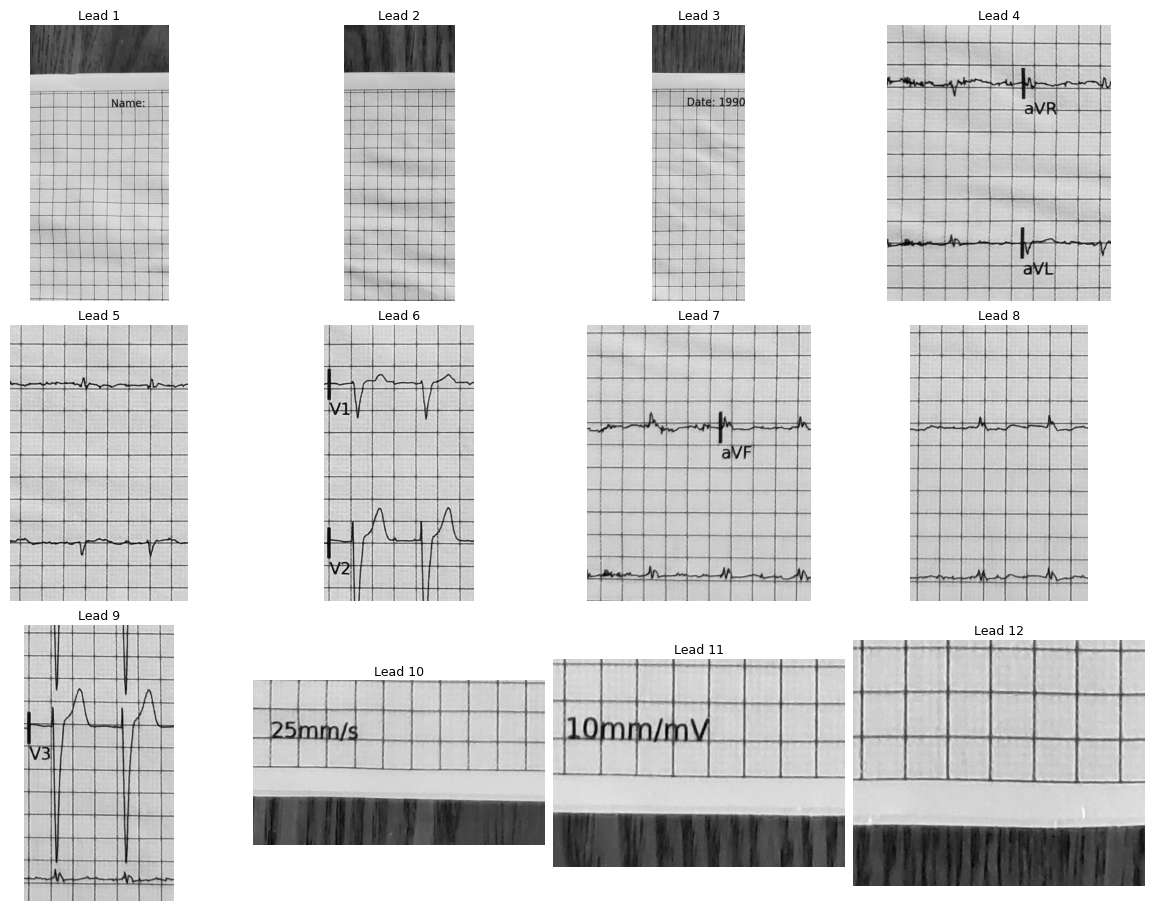

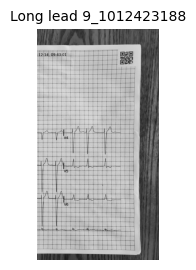

In [ ]:
def image_to_array(img: Image.Image) -> np.ndarray:
    if img.mode != 'L':
        img = img.convert('L')
    return np.array(img)


def preprocess_physionet(root_dir: Path):
    """
    Loop over GOOD_CATEGORIES, cut each page into:
    - 12 short leads
    - 1 long lead
    Store in nested dicts:
      small[cat][record_id] = list of 12 arrays
      long_leads[cat][record_id] = 1 array
    """
    small: Dict[str, Dict[str, List[np.ndarray]]] = {}
    long_leads: Dict[str, Dict[str, np.ndarray]] = {}

    for record_id, category, img_path in load_all_images(root_dir):
        img = Image.open(img_path)
        leads, long_lead = split_page(img, category)

        if len(leads) != 12:
            print(f"[SKIP] {record_id} cat {category}: {len(leads)} short leads")
            continue

        short_arrays = [image_to_array(lead) for lead in leads]
        long_array = image_to_array(long_lead)

        small.setdefault(category, {})[record_id] = short_arrays
        long_leads.setdefault(category, {})[record_id] = long_array

        print(f"[OK] {record_id} cat {category} -> 12 leads; long {long_array.shape}")

    return small, long_leads


In [ ]:
SAVE_DIR = Path("train_data")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

small_data, long_data = preprocess_physionet(ROOT_DIR)

np.savez_compressed(
    SAVE_DIR / 'physionet_leads_small.npz',
    **{
        f"{cat}_{rid}": np.array(leads, dtype=object)
        for cat, recs in small_data.items()
        for rid, leads in recs.items()
    },
)

np.savez_compressed(
    SAVE_DIR / 'physionet_long_leads.npz',
    **{
        f"{cat}_{rid}": arr
        for cat, recs in long_data.items()
        for rid, arr in recs.items()
    },
)

print("Saved to", SAVE_DIR)